In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge

In [61]:
def lorenz_derivatives(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """Compute time derivatives [dx/dt, dy/dt, dz/dt] for the Lorenz system."""
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [62]:
def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    """
    Numerically integrate Lorenz equations x'(t), y'(t), z'(t) using odeint.
    Returns: 
       t_vals: array of time points
       sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_derivatives, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

In [63]:
def scale_spectral_radius(W, target_radius=0.95):
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

In [64]:
class BaselineESN3D:
    """
    A baseline Echo State Network that handles:
      - 3D input (x,y,z)
      - 3D output (x(t+1), y(t+1), z(t+1))"
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        # Initialize W with small random values (mean=0, variance=0.01)
        W = np.random.randn(reservoir_size, reservoir_size) * 0.1
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 1)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(reservoir_size, 3) - 0.5) * 2.0 * self.input_scale
        
        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        """
        Single time-step ESN update:
          x(t+1) = (1-alpha)*x(t) + alpha*tanh( W*x(t) + W_in*u(t) )
        where u is R^3 (the Lorenz state).
        """
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha) * self.x + alpha * x_new

    def collect_states(self, inputs, discard=100):
        """
        Run reservoir on 'inputs' (shape [T, 3]), discarding the first 'discard' steps.
        Returns: states [T-discard, reservoir_size]
        """
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]
    
    def fit_readout(self, train_input, train_target, discard=100):
        """
        Teacher forcing for single-step:
          - input(t) = [x(t), y(t), z(t)]
          - target(t) = [x(t+1), y(t+1), z(t+1)]
        We collect states(t), then solve a multi-output ridge regression:
          W_out * [x(t); 1] ~ target(t+1).
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]  # shape [T-discard, 3]

        # Augment states with bias
        X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # [T-discard, N+1]

        ridge_reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        ridge_reg.fit(X_aug, targets_use)
        self.W_out = ridge_reg.coef_

    def predict(self, inputs):
        """
        Single-step-ahead inference on test data:
        For each inputs[t], we update reservoir, then read out 3D prediction.
        """
        self.reset_state()
        preds = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            x_aug = np.concatenate([self.x, [1.0]])  # (N+1,)
            out = self.W_out @ x_aug  # shape (3,)
            preds.append(out)
        return np.array(preds)
    
    def autoregressive_predict(self, inputs):
      """
      Autoregressive multi-step forecasting
      """
      self.reset_state()
      preds = []
      current_input = inputs[0]
    
      for t in range(len(inputs)):
          self._update(current_input)
          x_aug = np.concatenate([self.x, [1.0]])  # (N+1,)
          out = self.W_out @ x_aug  # shape (3,)
          preds.append(out)
          current_input = out
      
      return np.array(preds)

In [65]:
class CycleReservoir3D(BaselineESN3D):
    """
    Cyclic Reservoir for 3D -> 3D Lorenz.
    - reservoir_size, spectral_radius, input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        
        super().__init__()
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        # Build cycle adjacency: W[i,(i+1)%N] = 1
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W[i, j] = 1.0

        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 1)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

In [66]:
class SparseESN3D(BaselineESN3D):
    """
    Sparse ESN for 3D->3D Lorenz.
    - connectivity: fraction of non_zero entries in W
    - reservoir_size, spectral_radius, input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 connectivity=0.05,  # fraction of non-zero entries in W
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        # Initialize W with small random values (mean=0, variance=0.01)
        W = np.random.randn(reservoir_size, reservoir_size) * 0.1
        # Create a boolean sparsity mask
        mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
        W = W * mask
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 1)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

In [67]:
class HFR3D(BaselineESN3D):
    """
    Hierarchical Fractal Reservoir for 3D -> 3D Lorenz.
    - num_levels: number of fractal expansions
    - base_module_size: dimension of the base module
    - branching_factor: number of modules to replicate at each level
    - intra_scale, inter_scale: spectral radii for intra-block, inter-block
    - input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 num_levels=2,
                 base_module_size=50,
                 branching_factor=2,
                 intra_scale=0.95,
                 inter_scale=0.8,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        
        super().__init__()
        self.num_levels = num_levels
        self.base_module_size = base_module_size
        self.branching_factor = branching_factor
        self.intra_scale = intra_scale
        self.inter_scale = inter_scale
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        # Build fractal-like reservoir matrix W
        self.W = self._build_fractal_W()
        self.reservoir_size = self.W.shape[0]

        np.random.seed(self.seed + 1)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale
        

    def _build_fractal_W(self):
        np.random.seed(self.seed)
        # Base module
        base_size = self.base_module_size
        # Initialize base_block with small random values (mean=0, variance=0.01)
        base_block = np.random.randn(base_size, base_size) * 0.1
        base_block = scale_spectral_radius(base_block, self.intra_scale)

        current_W = base_block
        current_size = base_size

        for level in range(2, self.num_levels+1):
            n_mods = self.branching_factor
            block_size = current_size
            new_size = block_size * n_mods

            new_W = np.zeros((new_size, new_size))
            # replicate block along diagonal
            for m in range(n_mods):
                r0 = m * block_size
                new_W[r0:r0+block_size, r0:r0+block_size] = current_W
            
            # ring-style cross connections
            for m in range(n_mods):
                r0 = m*block_size
                c0 = ((m+1) % n_mods) * block_size
                cross_block = np.random.randn(block_size, block_size) * 0.1
                cross_block = scale_spectral_radius(cross_block, self.inter_scale)
                new_W[r0:r0+block_size, c0:c0+block_size] = cross_block

            current_W = new_W
            current_size = new_size

        return current_W


In [68]:
tmax = 30.0
dt = 0.01
t_vals, lorenz_trajectory = generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0], 
    tmax=tmax,
    dt=dt,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
)

In [69]:
# # Normalize data
data_min = lorenz_trajectory.min(axis=0)
data_max = lorenz_trajectory.max(axis=0)
lorenz_trajectory = (lorenz_trajectory - data_min) / (data_max - data_min)

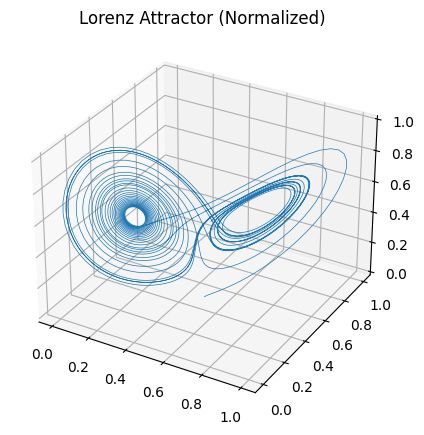

In [70]:
# Visualizing Lorenz attractor
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')
ax.plot(lorenz_trajectory[:, 0], lorenz_trajectory[:, 1], lorenz_trajectory[:, 2], lw=0.5)
ax.set_title("Lorenz Attractor (Normalized)")
plt.show()

In [71]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = lorenz_trajectory[:-1]
targets = lorenz_trajectory[1:]

In [72]:
# Train-test split
data_size = len(lorenz_trajectory)-1
train_ratio = 0.9
train_end = int(train_ratio * data_size)
train_input = inputs[:train_end]     # shape [train_end, 3]
train_target = targets[:train_end]   # shape [train_end, 3]
test_input  = inputs[train_end:]     # shape [T-train_end, 3]
test_target = targets[train_end:]    # shape [T-train_end, 3]

print(f"Total samples: {data_size}, train size: {train_end}, test size: {len(test_input)}")

Total samples: 2999, train size: 2699, test size: 300


## Teacher-forced Single-step Forecasting

In [73]:
# Baseline ESN
esn = BaselineESN3D(
    reservoir_size=400,
    spectral_radius=0.95,
    input_scale=1.0,
    leaking_rate=1.0,
    ridge_alpha=1e-6,
    seed=42
)
discard_esn = 100
esn.fit_readout(train_input, train_target, discard=discard_esn)
esn_preds = esn.predict(test_input)

In [74]:
# Cycle Reservoir
cycle_res = CycleReservoir3D(
    reservoir_size=400,
    spectral_radius=0.95,
    input_scale=1.0,
    leaking_rate=1.0,
    ridge_alpha=1e-6,
    seed=43
)
discard_cycle_res = 100
cycle_res.fit_readout(train_input, train_target, discard=discard_cycle_res)
cycle_res_preds = cycle_res.predict(test_input)

In [75]:
# Sparse ESN
sparse_esn = SparseESN3D(
    reservoir_size=400,
    spectral_radius=0.95,
    connectivity=0.05,
    input_scale=1.0,
    leaking_rate=1.0,
    ridge_alpha=1e-6,
    seed=44
)
discard_sparse_esn = 100
sparse_esn.fit_readout(train_input, train_target, discard=discard_sparse_esn)
sparse_esn_preds = sparse_esn.predict(test_input)

In [76]:
# HFR
hfr = HFR3D(
    num_levels=4,          
    base_module_size=50, 
    branching_factor=2,  
    intra_scale=0.95,
    inter_scale=0.05,
    input_scale=1.0,
    leaking_rate=1.0,
    ridge_alpha=1e-3,
    seed=42
)
discard_hfr = 100
hfr.fit_readout(train_input, train_target, discard=discard_hfr)
hfr_preds = hfr.predict(test_input)

In [77]:
# Compute dimension-wise MSE
mse_esn = np.mean((esn_preds - test_target)**2, axis=0)
mse_cycle_res = np.mean((cycle_res_preds - test_target)**2, axis=0)
mse_sparse_esn = np.mean((sparse_esn_preds - test_target)**2, axis=0)
mse_hfr = np.mean((hfr_preds - test_target)**2, axis=0)

print("Baseline ESN MSE :", mse_esn)
print("Cycle Res MSE    :", mse_cycle_res)
print("Sparse ESN MSE   :", mse_sparse_esn)
print("HFR MSE          :", mse_hfr)

Baseline ESN MSE : [0.00041559 0.00034738 0.00083293]
Cycle Res MSE    : [0.00047513 0.00021999 0.00108064]
Sparse ESN MSE   : [0.00036268 0.00030258 0.00105215]
HFR MSE          : [0.00031733 0.00020905 0.00058344]


In [78]:
# Compute overall MSE
overall_mse_esn = np.mean(mse_esn)
overall_mse_cycle_res = np.mean(mse_cycle_res)
overall_mse_sparse_esn = np.mean(mse_sparse_esn)
overall_mse_hfr = np.mean(mse_hfr)

print("Overall Baseline ESN MSE : {:.13f}".format(overall_mse_esn))
print("Overall Cycle Res MSE    : {:.13f}".format(overall_mse_cycle_res))
print("Overall Sparse           : {:.13f}".format(overall_mse_sparse_esn))
print("Overall HFR MSE          : {:.13f}".format(overall_mse_hfr))

Overall Baseline ESN MSE : 0.0005319660669
Overall Cycle Res MSE    : 0.0005919224103
Overall Sparse           : 0.0005724729066
Overall HFR MSE          : 0.0003699421784


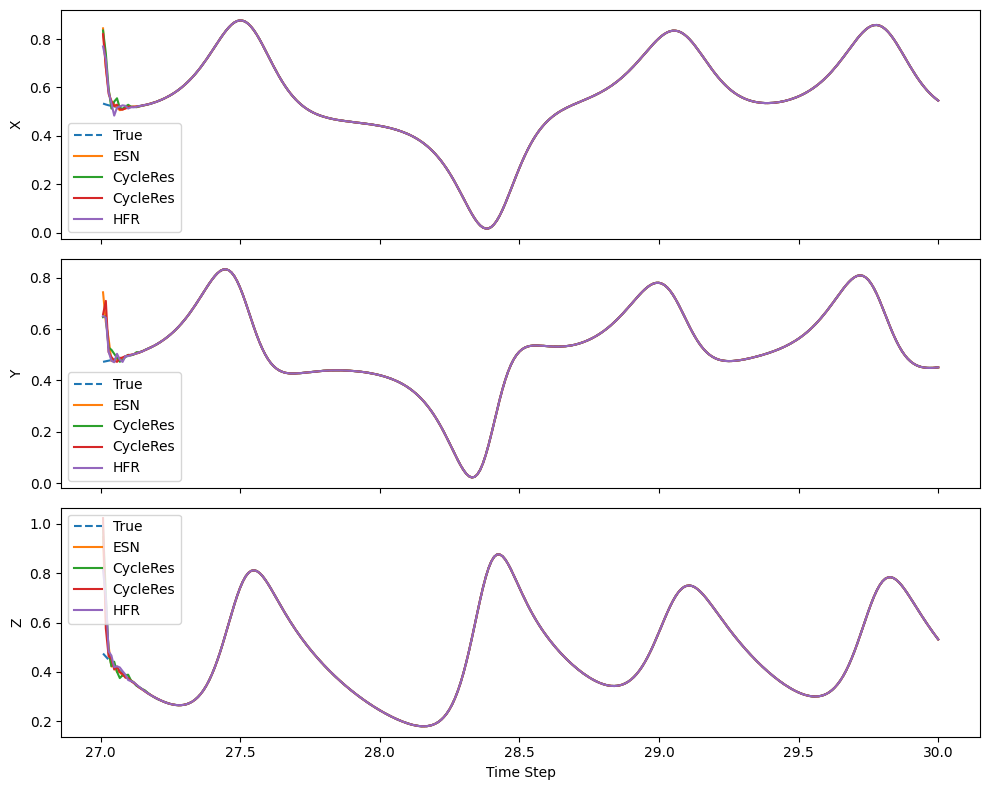

In [79]:
plot_len = len(test_input)
time_test = t_vals[train_end+1:train_end+1+plot_len]  # offset by 1 because targets are shifted

# Create subplots for x, y, z dimensions
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

dims = ['X', 'Y', 'Z']
for i in range(3):
    axes[i].plot(time_test, test_target[:plot_len, i], label='True', linestyle='dashed')
    axes[i].plot(time_test, esn_preds[:plot_len, i], label='ESN')
    axes[i].plot(time_test, cycle_res_preds[:plot_len, i], label='CycleRes')
    axes[i].plot(time_test, sparse_esn_preds[:plot_len, i], label='CycleRes')
    axes[i].plot(time_test, hfr_preds[:plot_len, i], label='HFR')
    axes[i].set_ylabel(dims[i])
    axes[i].legend()

# Set common X-axis label
axes[-1].set_xlabel('Time Step')

# Adjust layout
plt.tight_layout()
plt.show()

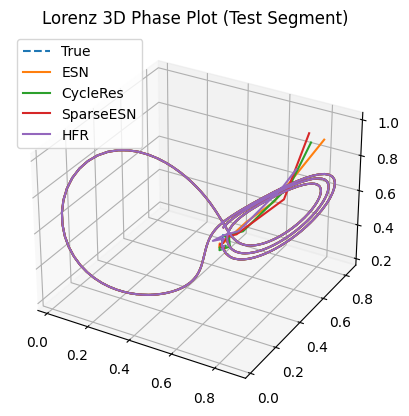

In [80]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2], label='True', linestyle='dashed')
ax.plot(esn_preds[:plot_len,0], esn_preds[:plot_len,1], esn_preds[:plot_len,2], label='ESN')
ax.plot(cycle_res_preds[:plot_len,0], cycle_res_preds[:plot_len,1], cycle_res_preds[:plot_len,2], label='CycleRes')
ax.plot(sparse_esn_preds[:plot_len,0], sparse_esn_preds[:plot_len,1], sparse_esn_preds[:plot_len,2], label='SparseESN')
ax.plot(hfr_preds[:plot_len,0], hfr_preds[:plot_len,1], hfr_preds[:plot_len,2], label='HFR')
ax.set_title('Lorenz 3D Phase Plot (Test Segment)')
ax.legend()
plt.show()

## Autoregressive Multi-step Forecasting

In [ ]:
# Baseline ESN
esn = BaselineESN3D(
    reservoir_size=400,
    spectral_radius=0.95,
    input_scale=1.0,
    leaking_rate=1.0,
    ridge_alpha=1e-6,
    seed=42
)
discard_esn = 100
esn.fit_readout(train_input, train_target, discard=discard_esn)
esn_preds = esn.autoregressive_predict(test_input)

In [ ]:
# HFR
hfr = HFR3D(
    num_levels=4,          
    base_module_size=50, 
    branching_factor=2,  
    intra_scale=0.95,
    inter_scale=0.05,
    input_scale=1.0,
    leaking_rate=1.0,
    ridge_alpha=1e-3,
    seed=42
)
discard_hfr = 100
hfr.fit_readout(train_input, train_target, discard=discard_hfr)
hfr_preds = hfr.autoregressive_predict(test_input)

In [ ]:
# Compute dimension-wise MSE
mse_esn = np.mean((esn_preds - test_target)**2, axis=0)
mse_hfr = np.mean((hfr_preds - test_target)**2, axis=0)

print("Baseline ESN MSE:", mse_esn)
print("HFR MSE         :", mse_hfr)

Baseline ESN MSE: [0.10332852 0.07551204 0.13393331]
HFR MSE         : [0.1415904  0.08836467 0.06346658]


In [ ]:
# Compute overall MSE
overall_mse_esn = np.mean(mse_esn)
overall_mse_hfr = np.mean(mse_hfr)

print("Overall ESN MSE: {:.6f}".format(overall_mse_esn))
print("Overall HFR MSE: {:.6f}".format(overall_mse_hfr))

Overall ESN MSE: 0.104258
Overall HFR MSE: 0.097807


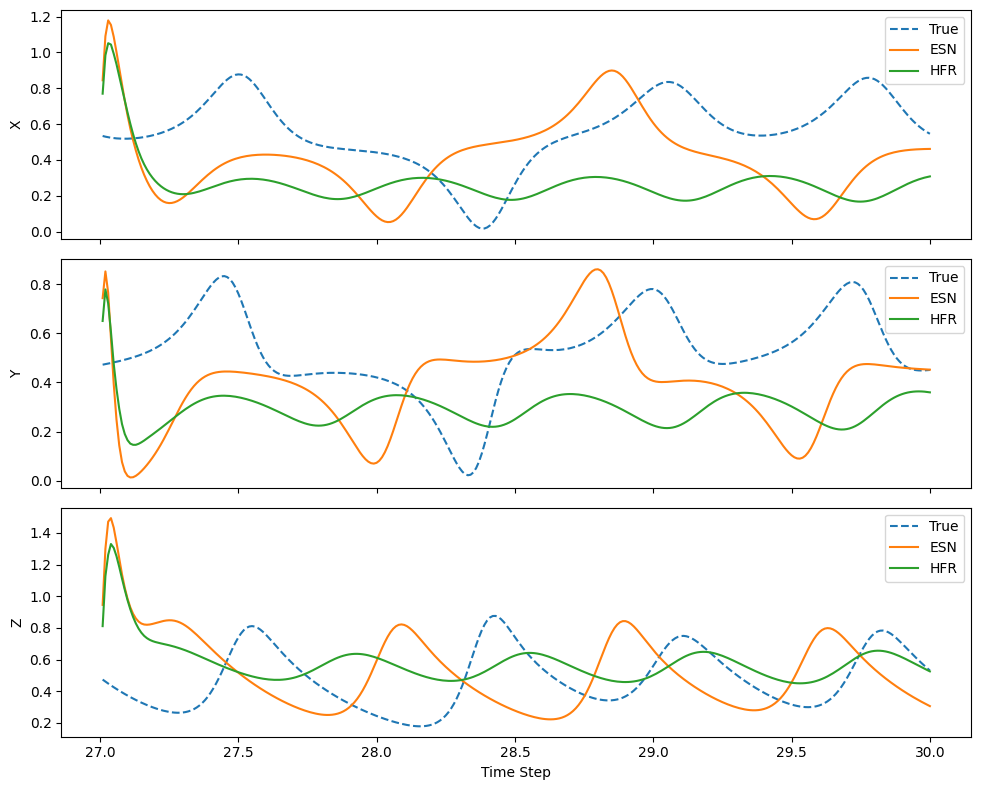

In [ ]:
plot_len = len(test_input)
time_test = t_vals[train_end+1:train_end+1+plot_len]  # offset by 1 because targets are shifted

# Create subplots for x, y, z dimensions
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

dims = ['X', 'Y', 'Z']
for i in range(3):
    axes[i].plot(time_test, test_target[:plot_len, i], label='True', linestyle='dashed')
    axes[i].plot(time_test, esn_preds[:plot_len, i], label='ESN')
    axes[i].plot(time_test, hfr_preds[:plot_len, i], label='HFR')
    axes[i].set_ylabel(dims[i])
    axes[i].legend()

# Set common X-axis label
axes[-1].set_xlabel('Time Step')

# Adjust layout
plt.tight_layout()
plt.show()

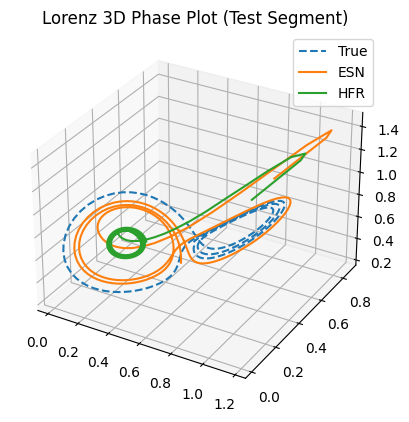

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2], label='True', linestyle='dashed')
ax.plot(esn_preds[:plot_len,0], esn_preds[:plot_len,1], esn_preds[:plot_len,2], label='ESN')
ax.plot(hfr_preds[:plot_len,0], hfr_preds[:plot_len,1], hfr_preds[:plot_len,2], label='HFR')
ax.set_title('Lorenz 3D Phase Plot (Test Segment)')
ax.legend()
plt.show()